In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pdb;
import time
import copy
from numpy import cos,sin,pi

In [2]:
# Robot dimensions
wheel_radius = 0.025
wheel_sep = 0.09
tail_dist = 0.075
L = 0.75
W = 0.5
dt = 0.01

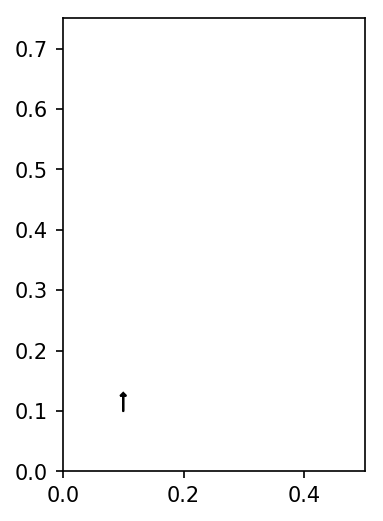

In [3]:
# Plot world
def show_world():
    plt.rcParams['figure.dpi'] = 150
    fig = plt.figure()
    ax=fig.add_subplot(111)
    plt.plot()
    
   
    plt.axis('equal')
    plt.axis([0,W,0,L])
    plt.gca().set_aspect('equal', adjustable='box')
    
    return ax
        
# Plot robot
def plot_robot(state,ax):      
    l = 0.025
    ax.arrow(state[0], state[1], l*np.cos(state[2]+pi/2), l*np.sin(state[2]+pi/2),width = 0.000001, head_width=0.01,head_length = 0.005)
            
  
ax = show_world()
plot_robot([0.1,0.1,0,0],ax)



In [4]:
# Calculated difference between angles
def get_angle_diff(a1,a2):
    ang_cw =  (a2 -a1)% (2*np.pi)
    ang_ccw = (- a2 + a1)% (2*np.pi)
    
    ang = np.minimum(ang_cw,ang_ccw) 
    if ang == ang_ccw:
        ang = - ang
    return ang

# Calculate distance between two points
def get_dist_diff(c1,c2):
    dist = np.sqrt(((c1[0] - c2[0])**2 + (c1[1] - c2[1])**2))
    return dist

print(get_angle_diff(0,0.1))
print(get_angle_diff(0,-0.1))
print(get_angle_diff(0,0))

0.1
-0.1
-0.0


In [5]:
def forward_dynamic(state,controls):
    wl,wr = controls
    x,y,th,w = state
    vr = wr*wheel_radius
    vl = wl*wheel_radius
    wc = (vr-vl)/wheel_sep
    if wl!=wr:
        Rc = wheel_sep/2*(vr+vl)/(vr-vl)
        cx = x - Rc*sin(th+pi/2)
        cy = y + Rc*cos(th+pi/2)
        d = wc*dt
        xd = (x-cx)*cos(d) - (y-cy)*sin(d) + cx
        yd = (x-cx)*sin(d) + (y-cy)*cos(d) + cy
        thd = (th+d)%(2*pi)
    else:
        v = vr
        d = v*dt
        xd =  x+d*sin(th)
        yd =  y+d*cos(th)
        thd = th
    wd = wc
    return [xd,yd,thd,wd]

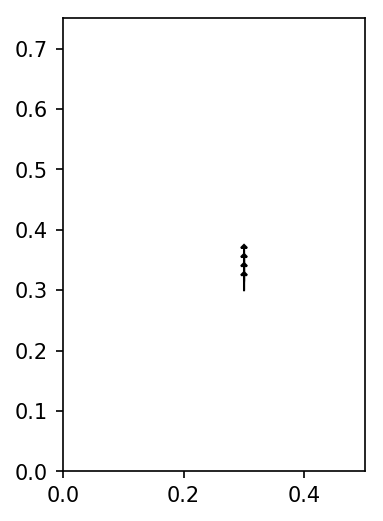

In [6]:
ax = show_world()
state = [0.3,0.3,0,0]
plot_robot(state,ax)
controls = [60,60]
for i in range(3):
    state = forward_dynamic(state,controls)
#     print(state)
    plot_robot(state,ax)

In [7]:
def state_to_sensor(state,noise_std = None):
    get_dist_x = lambda x :  [(x - state[0])/ np.cos(state[2]) , (x - state[0])/ np.cos(state[2]+pi/2)]
    get_dist_y = lambda x :  [(x - state[1])/ np.sin(state[2]), (x - state[1])/ np.sin(state[2]+pi/2)]
    get_line_x = lambda d :  [state[0] + d[0] * np.cos(state[2]) , state[0] + d[1] * np.cos(state[2]+pi/2)]
    get_line_y = lambda d :  [state[1] + d[0] * np.sin(state[2]),  state[1] + d[1] * np.sin(state[2]+pi/2)]


    
    rN,fN = get_dist_y(L)
    xrN,xfN = get_line_x([rN,fN])
 
    rS,fS = get_dist_y(0)
    xrS,xfS = get_line_x([rS,fS])
    
    rW,fW = get_dist_x(W)
    yrW,yfW = get_line_y([rW,fW])
    
    rE,fE = get_dist_x(0)
    yrE,yfE = get_line_y([rE,fE])
    
    def check_x(x):
        return x<=W and x>=0

    def check_y(y):
        return y<=L and y>=0
    
    
    ra =  [rN,rS,rW,rE]
    fa = [fN,fS,fW,fE]
    
    rb = [check_x(xrN) and rN>=0,check_x(xrS) and rS>=0,check_y(yrW) and rW>=0,check_y(yrE) and rE>=0]
    fb = [check_x(xfN) and fN>=0,check_x(xfS) and fS>=0,check_y(yfW) and fW>=0,check_y(yfE) and fE>=0]
    if sum(rb)!=1:
#         print(ra,rb)
#         1/0
        r = -1
    else:
        r = ra[rb.index(True)]
        if noise_std is not None:
            r = r + np.sqrt(noise_std[1])* np.random.randn()
        
    if sum(fb)!=1:
#         1/0
        f = -1
    else:
        f = fa[fb.index(True)]
        if noise_std is not None:
            f = f + np.sqrt(noise_std[0])* np.random.randn()
    
    th = (state[2]+pi/2)%(2*pi)
    w = state[3]
    if noise_std is not None:
         th = (th + np.sqrt(noise_std[2])* np.random.randn())%(2*pi)
         w = w + np.sqrt(noise_std[3])* np.random.randn()
    return [f,r,th,w]

0.75 0.5
[0.3, 0.65, 3.141592653589793, 0]
[0.3154365967369491, 0.7042812217976805, 3.1153669894992526, -0.07571543882111681]


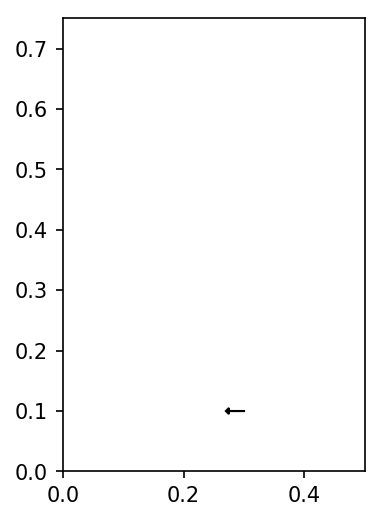

In [8]:
state = [0.3,0.1,np.pi/2,0]
measurement_noise_std = [.001,0.001,0.001,0.001]
print(L,W)
print(state_to_sensor(state))
print(state_to_sensor(state,measurement_noise_std))
ax = show_world()
plot_robot(state,ax)

In [9]:
def trace_traj(state,traj,actuation_noise_std = None,measurement_noise = None):
    state_seq = []
    obs_seq = []
    for c in traj:
        obs = state_to_sensor(state,measurement_noise)
        if actuation_noise_std is not None:
            c[0] += actuation_noise_std[0]*np.random.randn()
            c[1] += actuation_noise_std[1]*np.random.randn()
        state = forward_dynamic(state,c)
#         print(state)
        obs_seq.append(obs)
        state_seq.append(state)
    return (state_seq,obs_seq)

def plot_state_seq(states):
    ax = show_world()
    for state in states:
#         print(state)
        plot_robot(state,ax)

/home/samer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


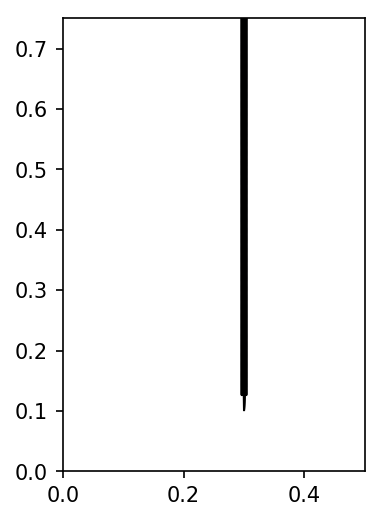

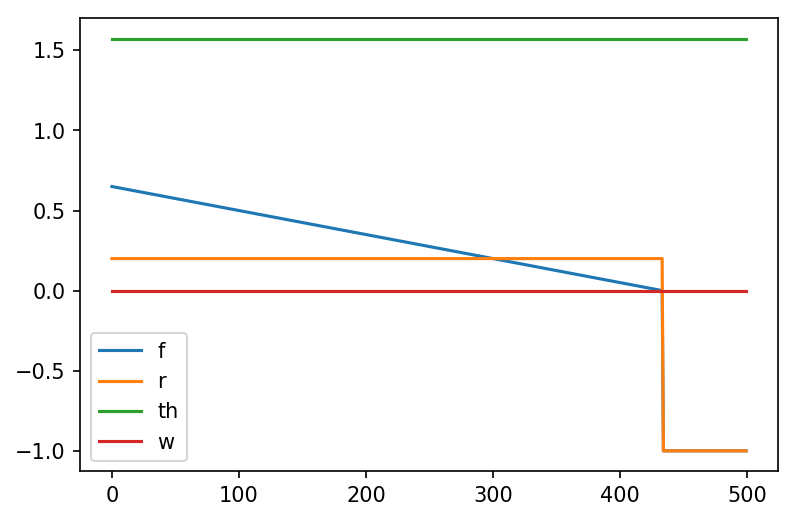

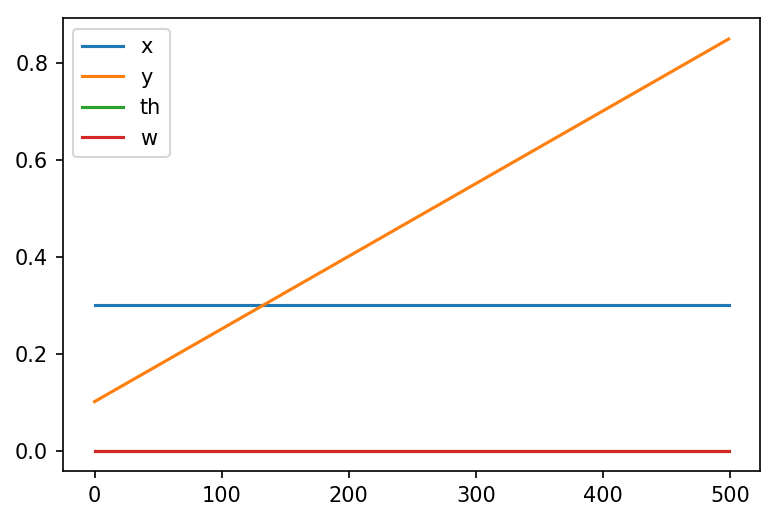

In [10]:
traj = [[6,6]]*500
state = [0.3,0.1,0,0]
state_seq,obs_seq = trace_traj(state,traj)
plot_state_seq(state_seq)
plt.figure()
plt.plot(np.array(obs_seq))
plt.legend(['f','r','th','w'])
plt.figure()
plt.plot(np.array(state_seq))
plt.legend(['x','y','th','w'])

/home/samer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


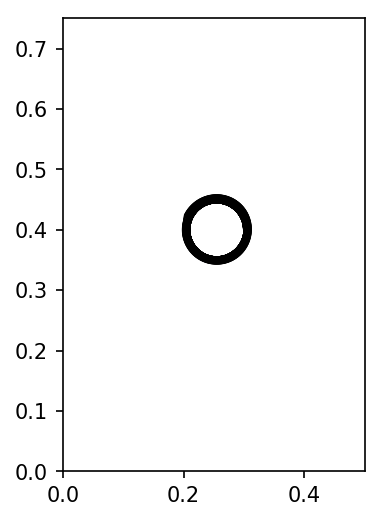

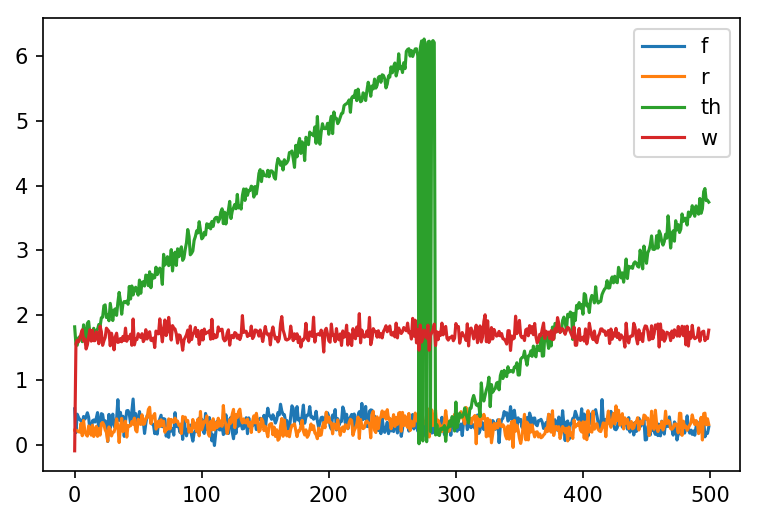

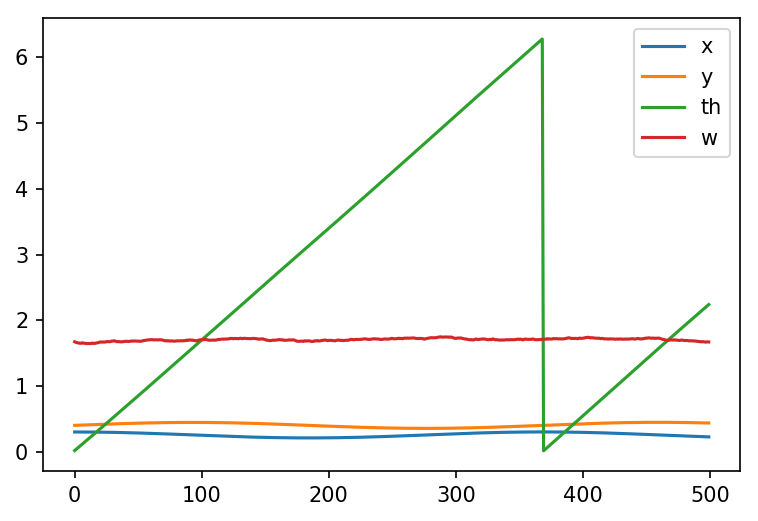

In [11]:
traj = [[0,6]]*500
state = [0.3,0.4,0,0]
actuation_noise_std = [0.01,0.01]
measurement_noise_std = [.01,0.01,0.01,0.01]
state_seq,obs_seq = trace_traj(state,traj,actuation_noise_std,measurement_noise_std)
plot_state_seq(state_seq)
plt.figure()
plt.plot(np.array(obs_seq))
plt.legend(['f','r','th','w'])
plt.figure()
plt.plot(np.array(state_seq))
plt.legend(['x','y','th','w'])

In [12]:
def calculate_sigma_points(state_mean,actuation_noise_cov,spreading = 3):
    state_mean = np.array(state_mean )
    sqrt_activ_noise_cov = np.linalg.cholesky(actuation_noise_cov)
    state_dim = len(state_mean)
    X = np.zeros((state_dim,state_dim*2+1))
    X[:,0] = state_mean
    X[:,1:state_dim+1] =  state_mean[:,None] + np.sqrt(state_dim+spreading)*sqrt_activ_noise_cov
    X[:,state_dim+1:] = state_mean[:,None]  - np.sqrt(state_dim+spreading)*sqrt_activ_noise_cov
    return X

sigma_test = calculate_sigma_points([0.3,0.4,0,0],1e-3*np.diag(np.ones(4)))
print(sigma_test[:,0:3])

[[0.3      0.383666 0.3     ]
 [0.4      0.4      0.483666]
 [0.       0.       0.      ]
 [0.       0.       0.      ]]


In [13]:
def predict(sigma_points,control_input,actuation_noise_cov,spreading = 3,forward_fun=forward_dynamic): 
    sigma_pred = np.zeros_like(sigma_points)
    state_dim,nsigma = sigma_points.shape
    sigma_pred[:,0] = forward_fun(sigma_points[:,0].tolist(),control_input)
    for i in range(1,nsigma):
        sigma_pred[:,i] =  forward_fun(sigma_points[:,i],control_input)
    W = np.zeros((nsigma))
    W[0] = spreading/(state_dim+spreading)
    W[1:] = 1/(2*(state_dim+spreading))
    mean_pred = np.sum(sigma_pred*W,axis = 1)
    cov_pred = np.zeros((state_dim,state_dim))
    for i in range(nsigma):
        cov_pred += np.outer(sigma_pred[:,i]-mean_pred,sigma_pred[:,i]-mean_pred)*W[i]
#     print(sigma_pred[:,0:3])
    cov_pred += actuation_noise_cov
    return mean_pred,cov_pred,sigma_pred

# print(forward_dynamic([0.3,0.4,0,0],[6,6]))
c_state_mean,c_state_cov,c_state_pred = predict(sigma_test,[6,6],1e-3*np.diag(np.ones(4)))
print(c_state_mean)
print(c_state_cov)


[0.3        0.40149925 0.         0.        ]
[[2.00000224e-03 3.23117427e-26 1.49825061e-06 0.00000000e+00]
 [3.23117427e-26 2.00000000e-03 0.00000000e+00 0.00000000e+00]
 [1.49825061e-06 0.00000000e+00 2.00000000e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e-03]]


In [14]:
def update(sigma_points,measurement_noise_cov,spreading = 3,measurement_fun = state_to_sensor): 
    state_dim,nsigma = sigma_points.shape
    measurement_dim = 4
    sigma_pred = np.zeros((measurement_dim,nsigma))
    for i in range(nsigma):
        sigma_pred[:,i] =  measurement_fun(sigma_points[:,i])
#     print(sigma_pred[:,0:3])
    W = np.zeros((nsigma,))
    W[0] = spreading/(state_dim+spreading)
    W[1:] = 1/(2*(state_dim+spreading))
    mean_pred = np.sum(sigma_pred*W,axis = 1)
    cov_pred = np.zeros((state_dim,state_dim))
    for i in range(nsigma):
        cov_pred += np.outer(sigma_pred[:,i]-mean_pred,sigma_pred[:,i]-mean_pred)*W[i]
    cov_pred+=measurement_noise_cov
    return mean_pred,cov_pred,sigma_pred
c_measure_mean,c_measure_cov,c_measure_pred = update(sigma_test,1e-3*np.diag(np.ones(4)))
print(c_measure_mean)
print(c_measure_cov)

[0.35017551 0.20010029 1.57079633 0.        ]
[[2.00018483e-03 1.05615147e-07 0.00000000e+00 0.00000000e+00]
 [1.05615147e-07 2.00006035e-03 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.00000000e-03]]


/home/samer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
def calc_kalman_gain(state_pred,state_mean,measure_pred,measure_mean,measure_cov):
    nsigma = state_pred.shape[1]
    cov_pred = np.zeros((state_pred.shape[0],measure_pred.shape[0]))
    for i in range(nsigma):
        cov_pred += np.outer(state_pred[:,i]-state_mean,measure_pred[:,i]-measure_mean)
    return cov_pred@np.linalg.inv(measure_cov)

kalman_gain = calc_kalman_gain(c_state_pred,c_state_mean,c_measure_pred,c_measure_mean,c_measure_cov)
print(kalman_gain)
# 

[[ 3.69607704e-04 -6.99978880e+00  1.04877543e-02  0.00000000e+00]
 [-6.99935838e+00  3.66638636e-04  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  7.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]


In [16]:
def kalman_update(pred_state,state_cov,pred_measure,measure_cov,  actual_measure ,kalman_gain):
    state = pred_state + kalman_gain@(actual_measure - pred_measure)
    cov = state_cov - kalman_gain@measure_cov@kalman_gain.T
    return (state,cov)
kalman_update(c_state_mean,c_state_cov,c_measure_mean,c_measure_cov,  [0.35,0.2 ,1.57079633, 0] ,kalman_gain)

(array([3.00701961e-01, 4.02727684e-01, 2.24357246e-08, 0.00000000e+00]),
 array([[-9.59972609e-02,  5.13294090e-06, -1.45330309e-04,
          0.00000000e+00],
        [ 5.13294090e-06, -9.59910901e-02,  0.00000000e+00,
          0.00000000e+00],
        [-1.45330309e-04,  0.00000000e+00, -9.60000000e-02,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e-03]]))

In [17]:
def kalman_step(state_noise_cov,measure_noise_cov,init_state, init_cov ,actual_measure):
    sigma_test = calculate_sigma_points(init_state,state_noise_cov)
    c_state_mean,c_state_cov,c_state_pred = predict(sigma_test,control_ip,state_noise_cov)
    c_measure_mean,c_measure_cov,c_measure_pred = update(sigma_test,measure_noise_cov)
    kalman_gain = calc_kalman_gain(c_state_pred,c_state_mean,c_measure_pred,c_measure_mean,c_measure_cov)
    op_state,op_cov=kalman_update(c_state_mean,c_state_cov,c_measure_mean,c_measure_cov,actual_measure ,kalman_gain)
    return op_state,op_cov
actual_measure = [0.35,0.2 ,1.57079633, 0]
state_noise_cov = 1e-3*np.diag(np.ones(4))
measure_noise_cov = 1e-3*np.diag(np.ones(4))
control_ip = [6,6]
init_state = [0.3,0.4,0,0]
init_cov = state_noise_cov

kalman_step(state_noise_cov,measure_noise_cov,init_state, init_cov ,actual_measure)

/home/samer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


(array([3.00701961e-01, 4.02727684e-01, 2.24357246e-08, 0.00000000e+00]),
 array([[-9.59972609e-02,  5.13294090e-06, -1.45330309e-04,
          0.00000000e+00],
        [ 5.13294090e-06, -9.59910901e-02,  0.00000000e+00,
          0.00000000e+00],
        [-1.45330309e-04,  0.00000000e+00, -9.60000000e-02,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e-03]]))

/home/samer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


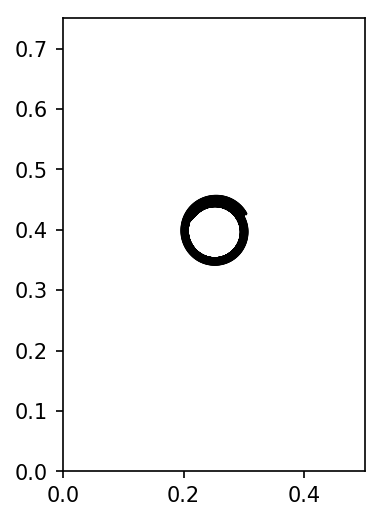

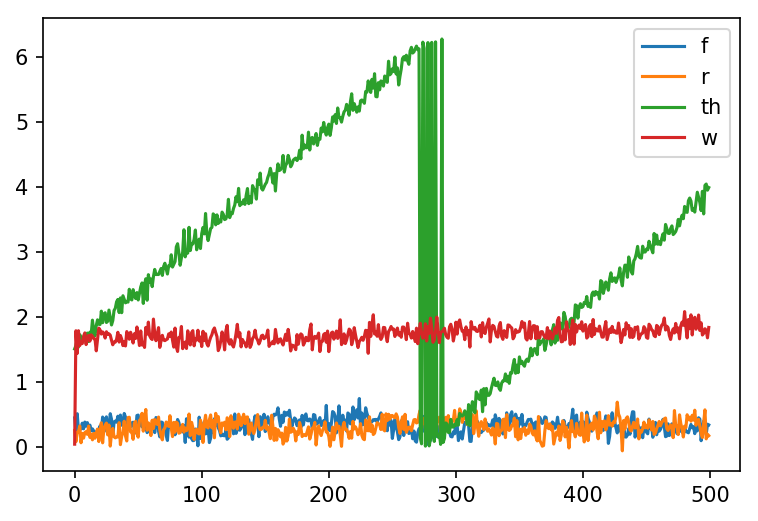

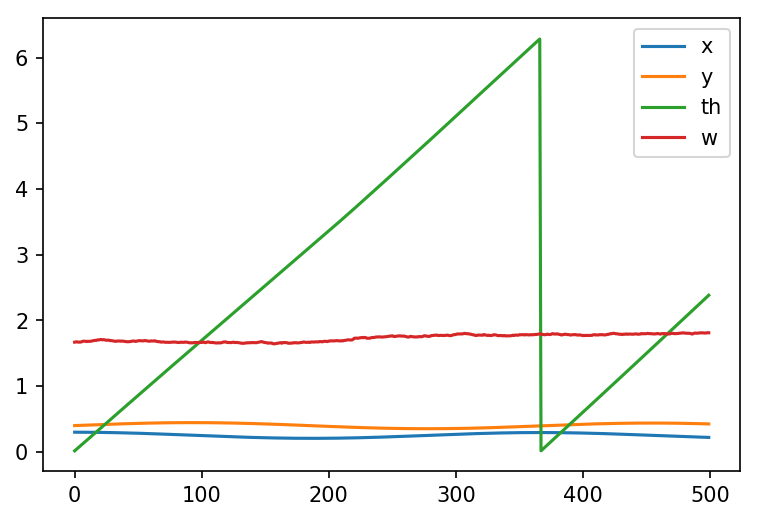

In [18]:
traj = [[0,6]]*500
state = [0.3,0.4,0,0]
actuation_noise_std = [0.01,0.01]
measurement_noise_std = [.01,0.01,0.01,0.01]
state_seq,obs_seq = trace_traj(state,traj,actuation_noise_std,measurement_noise_std)
plot_state_seq(state_seq)
plt.figure()
plt.plot(np.array(obs_seq))
plt.legend(['f','r','th','w'])
plt.figure()
plt.plot(np.array(state_seq))
plt.legend(['x','y','th','w'])

In [27]:
def apply_kalman(obs_seq,init_state,init_cov,state_noise_cov,measure_noise_cov):
    pred_state_seq = []
    c_sate = np.array(init_state)
    c_cov = init_cov
    for i in range(len(obs_seq)):
#         print(i)
        c_sate,c_cov= kalman_step(state_noise_cov,measure_noise_cov,c_sate, c_cov ,obs_seq[i])
        pred_state_seq.append(c_sate)
    return pred_state_seq
init_state = state_seq[0]
init_cov = np.zeros((4,4))
state_noise_cov = np.diag(measurement_noise_std)**2
measure_noise_cov = np.diag(measurement_noise_std)**2
pred_states = apply_kalman(obs_seq,init_state,init_cov,state_noise_cov,measure_noise_cov)


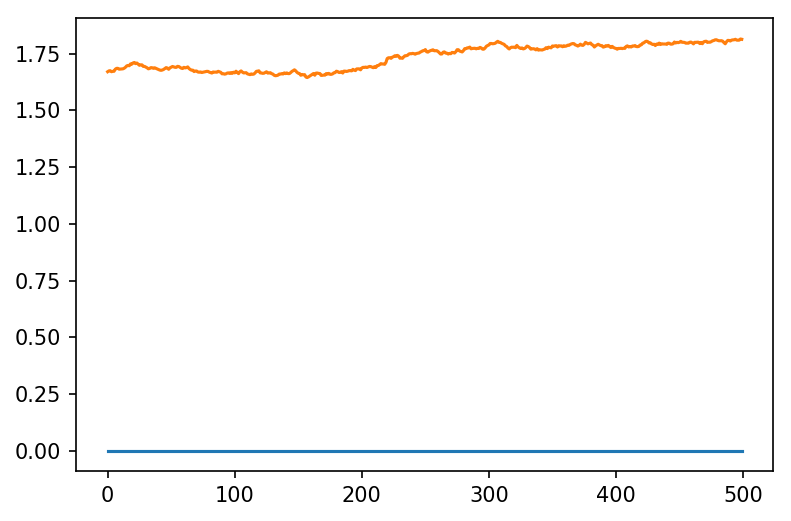

In [40]:
m_pred_states = np.array(pred_states)
m_true_states = np.array(state_seq)
plt.plot(m_pred_states[:,3])
plt.plot(m_true_states[:,3])

In [20]:
for _ in range(100):
    print()